# Muestreador de Gibbs

Juan Sosa PhD

Email: jcsosam@unal.edu.co

GitHub: https://github.com/jstats1702

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

from matplotlib.lines import Line2D
from scipy.stats import gamma
from scipy.stats import norm
from scipy.special import gammaln
from tabulate import tabulate
from statsmodels.graphics.tsaplots import plot_acf

# Introducción

El modelo Normal para **variables continuas** $y_i \in \mathbb{R}$, con $i = 1, \dots, n$, se define como:  
$$
\begin{aligned}
	y_i \mid \theta, \sigma^2 &\overset{\text{iid}}{\sim} \textsf{N}(\theta, \sigma^2) \\
	(\theta, \sigma^2) &\sim p(\theta, \sigma^2)
\end{aligned}
$$
donde $\boldsymbol{\theta} = (\theta, \sigma^2) \in \Theta = \mathbb{R} \times \mathbb{R}^+$.

Considere especificar el estado de información previo sobre $\theta$ de manera **independiente** de $\sigma^2$, de modo que $p(\theta,\sigma^2)=p(\theta)\,p(\sigma^2)$, donde 
$$
\theta\sim\textsf{N}(\mu_0,\tau^2_0)\qquad\text{y}\qquad\sigma^2\sim\textsf{GI}\left(\frac{\nu_0}{2},\frac{\nu_0\sigma^2_0}{2}\right),
$$  
siendo $\mu_0$, $\tau^2_0$, $\nu_0$ y $\sigma^2_0$ los hiperparámetros del modelo.

Esta formulación es **flexible** ya que **no impone una restricción de dependencia previa** entre $\theta$ y $\sigma^2$.

En el caso de una previa conjugada, donde $\tau_0^2$ es proporcional a $\sigma^2$, la distribución posterior de $\sigma^2$ sigue una Gamma Inversa. Sin embargo, en este caso, **la distribución posterior de $\sigma^2$ no corresponde a una distribución estándar**.

# Muetreador de Gibbs

El **muestreador de Gibbs** (*Gibbs sampler*) es un algoritmo que permite **generar muestras correlacionadas** de la distribución posterior utilizando las **distribuciones condicionales completas** de los parámetros.

Dado un **estado actual** de los parámetros del modelo $\boldsymbol{\theta}^{(b)} = (\theta^{(b)},\sigma^{2\,(b)})$, se genera un nuevo estado $\boldsymbol{\theta}^{(b+1)} = (\theta^{(b+1)},\sigma^{2\,(b+1)})$ mediante el siguiente procedimiento iterativo:  

1. Muestrear $\theta^{(b+1)}\sim p(\theta\mid\sigma^{2\,(b)},\boldsymbol{y})$.  
2. Muestrear $\sigma^{2\,(b+1)}\sim p(\sigma^2\mid\theta^{(b+1)},\boldsymbol{y})$.  
3. Actualizar $\boldsymbol{\theta}^{(b+1)} = (\theta^{(b+1)},\sigma^{2\,(b+1)})$.  
4. Repetir los pasos 1 a 3 hasta alcanzar la convergencia.

Este procedimiento genera una **secuencia dependiente** de muestras $\boldsymbol{\theta}^{(1)}, \ldots, \boldsymbol{\theta}^{(B)}$, que provienen de la distribución posterior $p(\theta, \sigma^2 \mid \boldsymbol{y})$.

El **muestreador de Gibbs** produce una **cadena de Markov** (*Markov chain*) $\boldsymbol{\theta}^{(1)},\dots,\boldsymbol{\theta}^{(B)}$, ya que cada nuevo estado $\boldsymbol{\theta}^{(b+1)}$ depende exclusivamente del estado anterior $\boldsymbol{\theta}^{(b)}$.

La **distribución estacionaria** de la cadena $\boldsymbol{\theta}^{(1)},\dots,\boldsymbol{\theta}^{(B)}$ es la **distribución posterior** $p(\boldsymbol{\theta} \mid \boldsymbol{y})$.

**Referencias**: 

- Smith, A. F. M., & Roberts, G. O. (1993). ***Bayesian computation via the Gibbs sampler and related Markov chain Monte Carlo methods.*** Journal of the Royal Statistical Society: Series B (Methodological), 55(1), 3–23.

## Distribuciones condicionales completas

Bajo el **modelo Normal con distribución previa semi-conjugada**, se tiene que:

- **(Ejercicio.)** La **distribución condicional completa** de $\theta$ es $\theta\mid\sigma^2,\boldsymbol{y}\sim\textsf{N}(\mu_n,\tau^2_n)$, donde
$$
\mu_n = \frac{\frac{1}{\tau^2_0}\mu_0 + \frac{n}{\sigma^2}\bar{y}}{\frac{1}{\tau^2_0} + \frac{n}{\sigma^2}} \qquad\text{y}\qquad\tau^2_n=\frac{1}{\frac{1}{\tau^2_0} + \frac{n}{\sigma^2}}\,.
$$
- **(Ejercicio.)** La **distribución condicional completa** de $\sigma^2$ es $\sigma^2\mid\theta,\boldsymbol{y}\sim\textsf{GI}\left(\tfrac{\nu_n}{2},\tfrac{\nu_n\,\sigma^2_n}{2}\right)$, donde
$$
\nu_n = \nu_0+n\qquad\text{y}\qquad \nu_n\sigma^2_n = \nu_0\sigma^2_0 + ns^2_\theta\,,
$$
con $s^2_\theta = \tfrac{1}{n}\sum_{i=1}^n (y_i-\theta)^2$, lo que corresponde a un estimador insesgado de $\sigma^2$ si $\theta$ fuera conocido. 

Como punto de partida, basta con **inicializar** a $\sigma^2$. Usualmente, este valor se genera a partir de la distribución previa, es decir, $\sigma^{2\,(0)}\sim\textsf{IG}\left(\tfrac{\nu_0}{2},\tfrac{\nu_0\sigma^2_0}{2}\right)$.

# Ejemplo: Puntajes de Matemáticas

La base de datos contiene la información de una **muestra aleatoria simple** de los **estudiantes que presentaron la Prueba Saber 11 en 2023-2**. 

La **prueba de matemáticas** está diseñada con una **escala de 0 a 100** (sin decimales), un **puntaje promedio de 50** y una **desviación estándar de 10 puntos**.

¿Existe suficiente evidencia para concluir que el puntaje promedio de Matemáticas de Bogotá es significativamente superior al puntaje promedio preestablecido por la prueba?

Los datos son públicos y están disponibles en este [enlace](https://www.icfes.gov.co/data-icfes/).

## Tratamiento de datos

In [5]:
# Cargar datos
dat = pd.read_csv("SB11_20232_muestra.txt", sep=";", dtype=str)

# Dimensiones del DataFrame
print(dat.shape)

# Distribución de frecuencias de la variable ESTU_DEPTO_RESIDE
print(dat["ESTU_DEPTO_RESIDE"].value_counts())

(5511, 83)
ESTU_DEPTO_RESIDE
BOGOTÁ             776
ANTIOQUIA          758
VALLE              401
CUNDINAMARCA       389
ATLANTICO          342
BOLIVAR            275
SANTANDER          274
CORDOBA            218
MAGDALENA          200
BOYACA             173
TOLIMA             170
CESAR              149
NORTE SANTANDER    147
NARIÑO             145
HUILA              126
CAUCA              126
RISARALDA          125
META               122
SUCRE              107
LA GUAJIRA         100
CALDAS              78
CHOCO               55
CASANARE            53
QUINDIO             45
CAQUETA             42
PUTUMAYO            38
ARAUCA              34
GUAVIARE            15
SAN ANDRES           9
AMAZONAS             8
VICHADA              4
GUAINIA              4
VAUPES               3
Name: count, dtype: int64


In [6]:
# Filtrar datos de Bogotá (código de departamento 11) y extraer la columna PUNT_MATEMATICAS
y = dat.loc[dat["ESTU_COD_RESIDE_DEPTO"] == "11", "PUNT_MATEMATICAS"].astype(float)

# Tamaño de la muestra
n = len(y)
print(n)

# Estadísticos suficientes: media y varianza muestral
yb = np.mean(y)
s2 = np.var(y, ddof=1)  # ddof=1 para varianza muestral (como en R)
print(yb)
print(s2)

776
55.08247422680412
143.8486730961093


## Muestreador de Gibbs

In [8]:
# Semilla para reproducibilidad
np.random.seed(123)

# Hiperparámetros
mu0  = 50
t20  = 10**2  # Regla empírica: P(|theta - mu0| < 3*tau0) = 99.7%
s20  = 10**2
nu0  = 1

# Número de muestras
B = 10000

# Matriz para almacenar muestras
THETA = np.empty((B, 2))

# Inicialización
sig2 = 1 / gamma.rvs(a=nu0 / 2, scale=2 / (nu0 * s20))

# Muestreador de Gibbs
for b in range(B):
    # Actualización de theta
    t2n = 1 / (1 / t20 + n / sig2)
    mun = t2n * (mu0 / t20 + n * yb / sig2)
    theta = norm.rvs(loc=mun, scale=np.sqrt(t2n))
    
    # Actualización de sigma^2
    nun = nu0 + n
    s2n = (nu0 * s20 + np.sum((y - theta)**2)) / nun
    sig2 = 1 / gamma.rvs(a=nun / 2, scale=2 / (nun * s2n))
    
    # Guardar muestras
    THETA[b, :] = [theta, sig2]
    
    # Mostrar progreso cada 10%
    if b % (B // 10) == 0:
        print(f"{100 * b // B}% completado...")

# Convertir a DataFrame
THETA = pd.DataFrame(THETA, columns=["theta", "sigma2"])

0% completado...
10% completado...
20% completado...
30% completado...
40% completado...
50% completado...
60% completado...
70% completado...
80% completado...
90% completado...


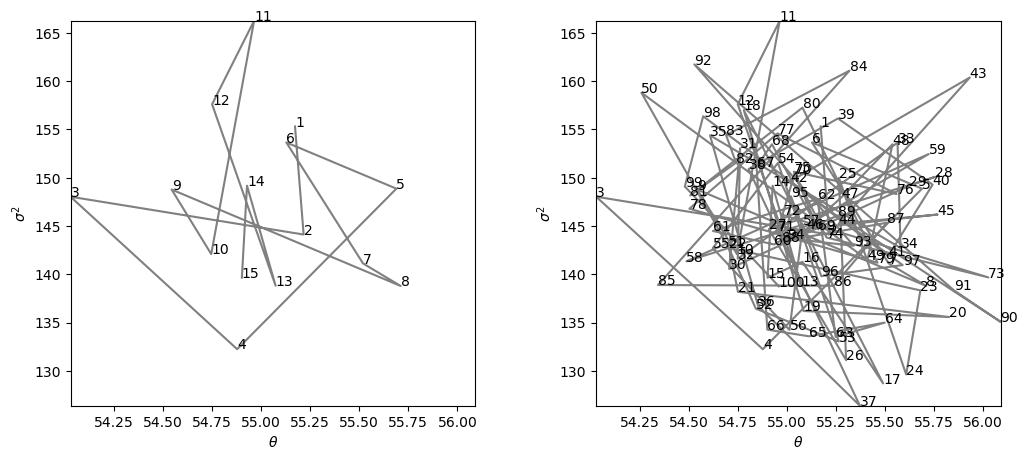

In [9]:
# Parámetros para las iteraciones a visualizar
iteraciones = [15, 100]

# Ajustar estilo del gráfico
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)

# Rango para ejes
xlim = (THETA["theta"][:100].min(), THETA["theta"][:100].max())
ylim = (THETA["sigma2"][:100].min(), THETA["sigma2"][:100].max())

# Graficar las trayectorias
for ax, m1 in zip(axes, iteraciones):
    ax.plot(THETA["theta"][:m1], THETA["sigma2"][:m1], color="gray", linestyle="-")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$\sigma^2$")
    for i in range(m1):
        ax.text(THETA["theta"][i], THETA["sigma2"][i], str(i + 1), fontsize=10)

plt.show()

## Cadenas

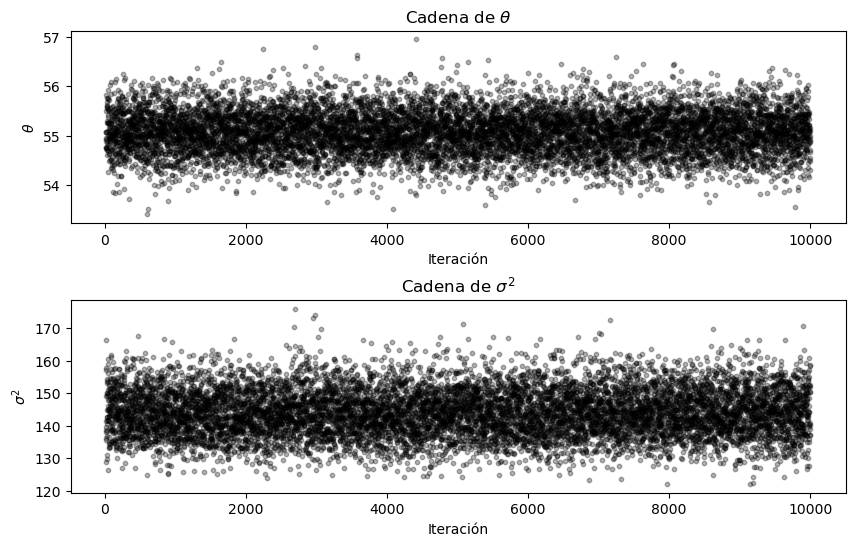

In [11]:
# Crear figura con 2 subgráficos
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plt.subplots_adjust(hspace=0.4)

# Iteraciones sin el burn-in (primeras 10)
burnin = 10
iteraciones = np.arange(burnin + 1, len(THETA) + 1)

# Gráfico de la cadena para theta
axes[0].scatter(iteraciones, THETA["theta"][burnin:], 
                s=10, color=(0, 0, 0, 0.3))  # color negro con alpha 0.3
axes[0].set_xlabel("Iteración")
axes[0].set_ylabel(r"$\theta$")
axes[0].set_title(r"Cadena de $\theta$")

# Gráfico de la cadena para sigma^2
axes[1].scatter(iteraciones, THETA["sigma2"][burnin:], 
                s=10, color=(0, 0, 0, 0.3))
axes[1].set_xlabel("Iteración")
axes[1].set_ylabel(r"$\sigma^2$")
axes[1].set_title(r"Cadena de $\sigma^2$")

plt.show()

## Distribución posterior

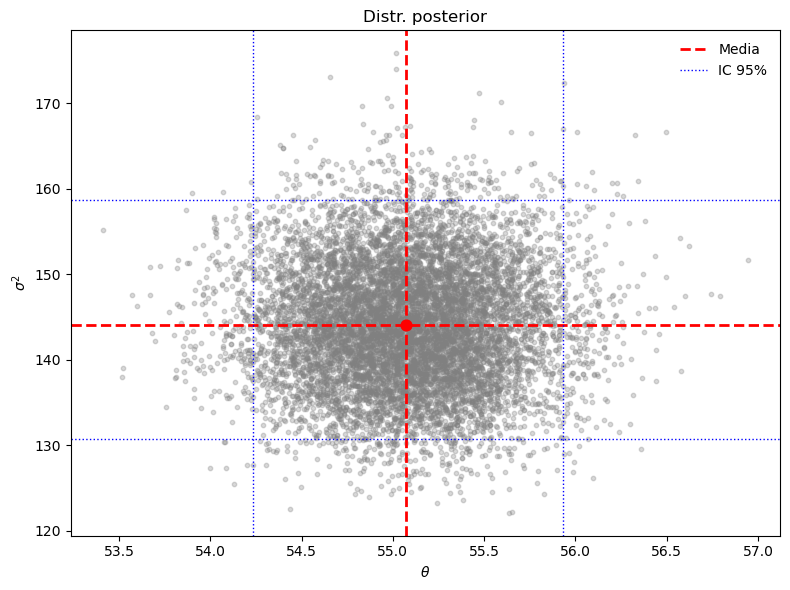

In [13]:
# Cálculo de estadísticas resumen
theta_mean  = THETA["theta"].mean()
sigma2_mean = THETA["sigma2"].mean()
theta_ci    = np.quantile(THETA["theta"], [0.025, 0.975])
sigma2_ci   = np.quantile(THETA["sigma2"], [0.025, 0.975])

# Crear gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(THETA["theta"], THETA["sigma2"], 
            color="gray", alpha=0.3, s=10)

# Etiquetas y título
plt.xlabel(r"$\theta$")
plt.ylabel(r"$\sigma^2$")
plt.title("Distr. posterior")

# Líneas de la media posterior (en rojo, línea interrumpida)
plt.axvline(theta_mean, color='red', linewidth=2, linestyle='--')
plt.axhline(sigma2_mean, color='red', linewidth=2, linestyle='--')

# Punto de la media posterior (en rojo)
plt.scatter(theta_mean, sigma2_mean, color='red', s=60, zorder=5)

# Líneas de los intervalos de credibilidad (en azul, línea punteada)
plt.axvline(theta_ci[0], color='blue', linewidth=1, linestyle=':')
plt.axvline(theta_ci[1], color='blue', linewidth=1, linestyle=':')
plt.axhline(sigma2_ci[0], color='blue', linewidth=1, linestyle=':')
plt.axhline(sigma2_ci[1], color='blue', linewidth=1, linestyle=':')

# Leyenda
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Media'),
    Line2D([0], [0], color='blue', lw=1, linestyle=':', label='IC 95%')
]
plt.legend(handles=custom_lines, loc="upper right", frameon=False)

plt.tight_layout()
plt.show()

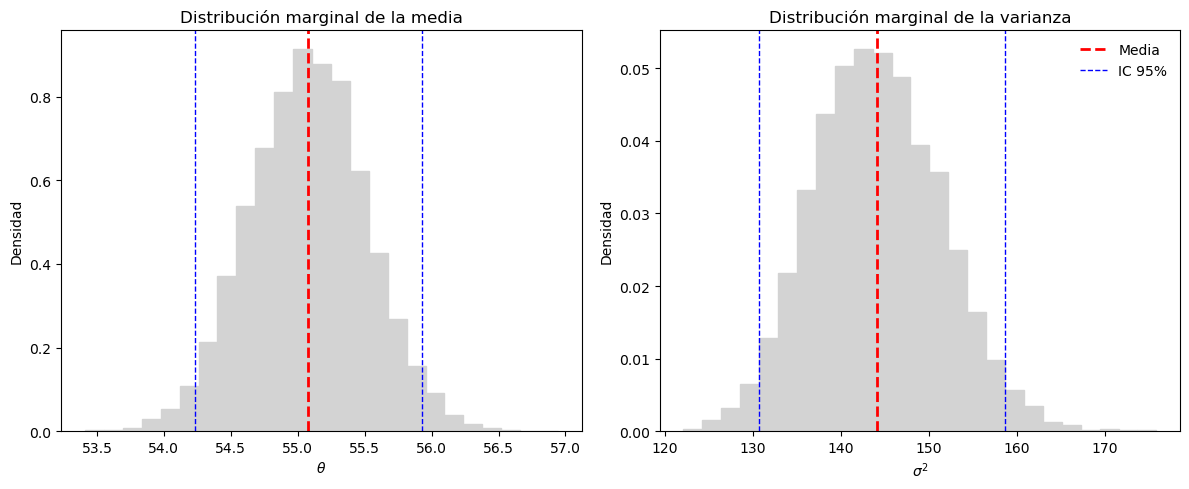

In [14]:
# Crear figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)

# Histograma de theta
axes[0].hist(THETA["theta"], bins=25, color='lightgray', edgecolor='lightgray', density=True)
axes[0].set_xlabel(r"$\theta$")
axes[0].set_ylabel("Densidad")
axes[0].set_title("Distribución marginal de la media")

# Líneas verticales: media y IC 95%
axes[0].axvline(theta_mean, color='red', linewidth=2, linestyle='--')
axes[0].axvline(theta_ci[0], color='blue', linewidth=1, linestyle='--')
axes[0].axvline(theta_ci[1], color='blue', linewidth=1, linestyle='--')

# Histograma de sigma^2
axes[1].hist(THETA["sigma2"], bins=25, color='lightgray', edgecolor='lightgray', density=True)
axes[1].set_xlabel(r"$\sigma^2$")
axes[1].set_ylabel("Densidad")
axes[1].set_title("Distribución marginal de la varianza")

# Líneas verticales: media y IC 95%
axes[1].axvline(sigma2_mean, color='red', linewidth=2, linestyle='--')
axes[1].axvline(sigma2_ci[0], color='blue', linewidth=1, linestyle='--')
axes[1].axvline(sigma2_ci[1], color='blue', linewidth=1, linestyle='--')

# Leyenda común
custom_lines = [
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Media'),
    Line2D([0], [0], color='blue', lw=1, linestyle='--', label='IC 95%')
]
axes[1].legend(handles=custom_lines, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

In [15]:
# Construcción de la tabla
tab = pd.DataFrame({
    "Estimación": [THETA["theta"].mean(), THETA["sigma2"].mean()],
    "CV": [
        THETA["theta"].std() / THETA["theta"].mean(),
        THETA["sigma2"].std() / THETA["sigma2"].mean()
    ],
    "L. Inf. 95%": [
        np.quantile(THETA["theta"], 0.025),
        np.quantile(THETA["sigma2"], 0.025)
    ],
    "L. Sup. 95%": [
        np.quantile(THETA["theta"], 0.975),
        np.quantile(THETA["sigma2"], 0.975)
    ]
}, index=["Media", "Varianza"])

# Redondear a 3 cifras decimales
tab = tab.round(3)

# Mostrar tabla
print("Inferencia sobre la media y la varianza:\n")
print(tab.to_markdown(tablefmt="grid"))

Inferencia sobre la media y la varianza:

+----------+--------------+-------+---------------+---------------+
|          |   Estimación |    CV |   L. Inf. 95% |   L. Sup. 95% |
+==========+==============+=======+===============+===============+
| Media    |       55.075 | 0.008 |        54.232 |        55.931 |
+----------+--------------+-------+---------------+---------------+
| Varianza |      144.121 | 0.05  |       130.735 |       158.673 |
+----------+--------------+-------+---------------+---------------+


## Distriución predictiva

In [17]:
# Fijar semilla
np.random.seed(1234)

# Simular desde la distribución predictiva posterior
y_new = np.random.normal(loc=THETA["theta"], scale=np.sqrt(THETA["sigma2"]))

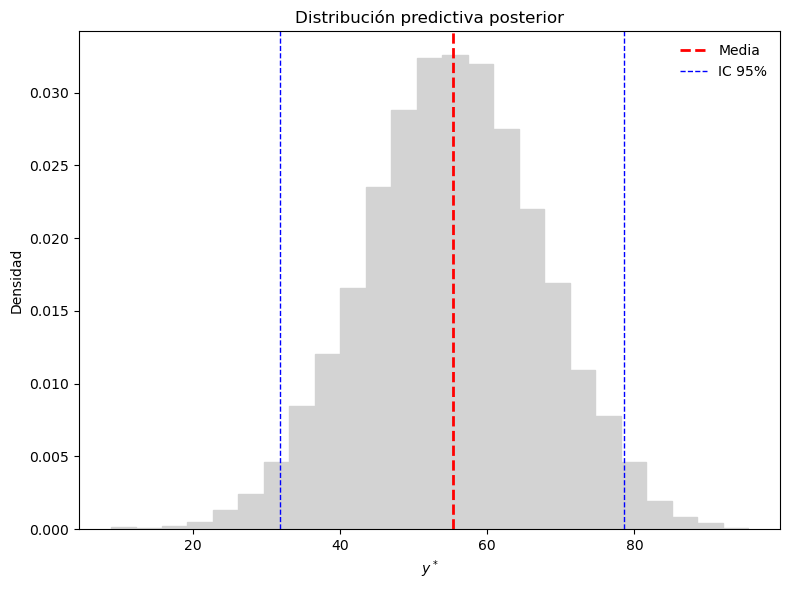

In [18]:
# Calcular estadísticos de la distribución predictiva
y_mean = np.mean(y_new)
y_ci = np.quantile(y_new, [0.025, 0.975])

# Crear figura
plt.figure(figsize=(8, 6))

# Histograma de la distribución predictiva posterior
plt.hist(y_new, bins=25, density=True, color='lightgray', edgecolor='lightgray')

# Etiquetas y título
plt.xlabel(r"$y^*$")
plt.ylabel("Densidad")
plt.title("Distribución predictiva posterior")

# Línea de la media (rojo, interrumpida)
plt.axvline(y_mean, color='red', linewidth=2, linestyle='--')

# Líneas del intervalo de credibilidad al 95% (azul, interrumpidas)
plt.axvline(y_ci[0], color='blue', linewidth=1, linestyle='--')
plt.axvline(y_ci[1], color='blue', linewidth=1, linestyle='--')

# Leyenda
custom_lines = [
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Media'),
    Line2D([0], [0], color='blue', lw=1, linestyle='--', label='IC 95%')
]
plt.legend(handles=custom_lines, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

In [19]:
# Calcular estadísticas resumen para y_new
tab = pd.DataFrame({
    "Estimación": [np.mean(y_new)],
    "CV": [np.std(y_new) / np.mean(y_new)],
    "L. Inf. 95%": [np.quantile(y_new, 0.025)],
    "L. Sup. 95%": [np.quantile(y_new, 0.975)]
}, index=["y pred"])

# Redondear a 3 cifras decimales
tab = tab.round(3)

# Mostrar tabla
print("Inferencia sobre una predicción:\n")
print(tab.to_markdown(tablefmt="grid"))

Inferencia sobre una predicción:

+--------+--------------+-------+---------------+---------------+
|        |   Estimación |    CV |   L. Inf. 95% |   L. Sup. 95% |
+========+==============+=======+===============+===============+
| y pred |       55.268 | 0.216 |        31.844 |        78.577 |
+--------+--------------+-------+---------------+---------------+


## Chequeo del modelo

In [21]:
# Estadísticos observados
t_obs = [np.mean(y), np.std(y)]

# Inicializar matriz para almacenar estadísticas replicadas
t_mc = np.empty((B, 2))

# Distribución predictiva posterior replicada
np.random.seed(1234)
for i in range(B):
    y_rep = np.random.normal(loc=THETA["theta"][i], scale=np.sqrt(THETA["sigma2"][i]), size=n)
    t_mc[i, 0] = np.mean(y_rep)
    t_mc[i, 1] = np.std(y_rep)

# Cálculo de ppp
ppp_media = np.round(np.mean(t_mc[:, 0] < t_obs[0]), 3)
ppp_sd    = np.round(np.mean(t_mc[:, 1] < t_obs[1]), 3)

# Mostrar resultados
print(f"ppp (media): {ppp_media}")
print(f"ppp (desviación estándar): {ppp_sd}")

ppp (media): 0.505
ppp (desviación estándar): 0.492


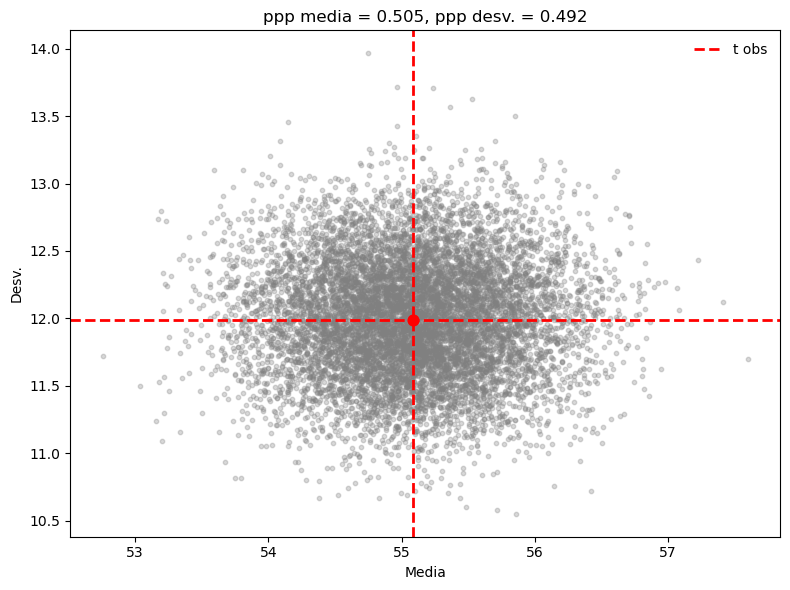

In [22]:
# Crear figura
plt.figure(figsize=(8, 6))

# Gráfico de dispersión: estadísticas de prueba replicadas
plt.scatter(t_mc[:, 0], t_mc[:, 1], color='gray', alpha=0.3, s=10)

# Etiquetas
plt.xlabel("Media")
plt.ylabel("Desv.")
plt.title(f"ppp media = {ppp_media}, ppp desv. = {ppp_sd}")

# Líneas rojas para los valores observados
plt.axvline(t_obs[0], color='red', linestyle='--', linewidth=2)
plt.axhline(t_obs[1], color='red', linestyle='--', linewidth=2)

# Punto observado
plt.scatter(t_obs[0], t_obs[1], color='red', s=60, zorder=5)

# Leyenda
custom_line = Line2D([0], [0], color='red', lw=2, linestyle='--', label='t obs')
plt.legend(handles=[custom_line], loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

## Inferencia: Bogotá

In [24]:
# Estadísticas básicas
s2 = np.var(y, ddof=1)
yb = np.mean(y)
n = len(y)

# Inferencia Bayesiana
est_B = THETA["theta"].mean()
cv_B  = THETA["theta"].std() / est_B
ic_B  = np.quantile(THETA["theta"], [0.025, 0.975])

# Inferencia Frecuentista Asintótica
est_F1 = yb
cv_F1  = np.sqrt(s2 / n) / yb
ic_F1  = yb + np.array([-1, 1]) * norm.ppf(0.975) * np.sqrt(s2 / n)

# Bootstrap paramétrico
np.random.seed(123)
out_par = np.mean(np.random.normal(loc=yb, scale=np.sqrt(s2), size=(10000, n)), axis=1)
est_F2 = np.mean(out_par)
cv_F2  = np.std(out_par) / est_F2
ic_F2  = np.quantile(out_par, [0.025, 0.975])

# Bootstrap no paramétrico
np.random.seed(123)
out_npar = np.mean(np.random.choice(y, size=(10000, n), replace=True), axis=1)
est_F3 = np.mean(out_npar)
cv_F3  = np.std(out_npar) / est_F3
ic_F3  = np.quantile(out_npar, [0.025, 0.975])

# Crear tabla
tab = pd.DataFrame([
    [est_B,  cv_B,  ic_B[0],  ic_B[1]],
    [est_F1, cv_F1, ic_F1[0], ic_F1[1]],
    [est_F2, cv_F2, ic_F2[0], ic_F2[1]],
    [est_F3, cv_F3, ic_F3[0], ic_F3[1]]
], columns=["Estimación", "CV", "L. Inf. 95%", "L. Sup. 95%"],
   index=["Bayesiana", "Frec. Asintótica", "Frec. Bootstrap Par.", "Frec. Bootstrap No Par."])

# Redondear
tab = tab.round(3)

# Mostrar tabla
print("Inferencia sobre el puntaje promedio de Matemáticas en Bogotá:\n")
print(tab.to_markdown(tablefmt="grid"))

Inferencia sobre el puntaje promedio de Matemáticas en Bogotá:

+-------------------------+--------------+-------+---------------+---------------+
|                         |   Estimación |    CV |   L. Inf. 95% |   L. Sup. 95% |
+=========================+==============+=======+===============+===============+
| Bayesiana               |       55.075 | 0.008 |        54.232 |        55.931 |
+-------------------------+--------------+-------+---------------+---------------+
| Frec. Asintótica        |       55.082 | 0.008 |        54.239 |        55.926 |
+-------------------------+--------------+-------+---------------+---------------+
| Frec. Bootstrap Par.    |       55.084 | 0.008 |        54.238 |        55.938 |
+-------------------------+--------------+-------+---------------+---------------+
| Frec. Bootstrap No Par. |       55.083 | 0.008 |        54.242 |        55.925 |
+-------------------------+--------------+-------+---------------+---------------+


# Algoritmo general

Dado un **estado actual** $\boldsymbol{\theta}^{(b)} = (\theta_1^{(b)},\ldots,\theta_k^{(b)})$, se genera un **nuevo estado** $\boldsymbol{\theta}^{(b+1)}$ de la siguiente manera:

1. Muestrear $\theta_1^{(b+1)}\sim p\left(\theta_1\mid\theta_2^{(b)},\theta_3^{(b)},\ldots,\theta_k^{(b)}\right)$.
2. Muestrear $\theta_2^{(b+1)}\sim p\left(\theta_2\mid\theta_1^{(b+1)},\theta_3^{(b)},\ldots,\theta_k^{(b)}\right)$.
3. Muestrear $\theta_3^{(b+1)}\sim p\left(\theta_3\mid\theta_1^{(b+1)},\theta_2^{(b+1)},\ldots,\theta_k^{(b)}\right)$.
4. \(\vdots\)
5. Muestrear $\theta_k^{(b+1)}\sim p\left(\theta_k\mid\theta_1^{(b+1)},\theta_2^{(b+1)},\ldots,\theta_{k-1}^{(b+1)}\right)$.
6. Definir $\boldsymbol{\theta}^{(b+1)} = (\theta_1^{(b+1)},\ldots,\theta_k^{(b+1)})$.
7. Repetir los pasos 1 a 6 hasta alcanzar la convergencia.

## Cadenas de Markov

Un **proceso estocástico** es una colección de variables aleatorias $\{\theta_t\in S:t\in T\}$, donde $S$ representa el **espacio de estados**, que puede ser **discreto**, e.g., $\{1,\ldots,k\}$, o **continuo**, e.g., $(-\infty,\infty)$, y $T$ representa el **conjunto de índices**, que puede ser **discreto**, e.g., $\{0,1,\ldots\}$, o **continuo**, e.g., $[0,\infty)$.  

Un proceso estocástico $\{\theta_t\in S:t\in T\}$ con $T=\{0,1,\ldots\}$ se denomina **cadena de Markov** si, para todo $A\subset S$, se cumple que  
$$
\textsf{Pr}(\theta_{t+1}\in A\mid \theta_0,\ldots,\theta_t) = \textsf{Pr}(\theta_{t+1}\in A\mid\theta_t)\,.
$$

## Cadenas de Markov ergódicas

Una **cadena de Markov ergódica** posee propiedades que garantizan su convergencia hacia un **comportamiento estable a largo plazo**, es decir, a una **distribución estacionaria**.  

Para que una cadena de Markov sea ergódica, debe cumplir las siguientes condiciones:  

- **Irreducibilidad:** Cualquier estado $i$ puede alcanzarse desde cualquier otro estado $j$ en un número finito de pasos con probabilidad positiva.  

- **Aperiodicidad:** No existe un período fijo $d > 1$ que restrinja las visitas a cada estado a múltiplos de $d$.

- **Recurrencia positiva:** Todo estado $i$ tiene un tiempo de retorno esperado finito.  

Cuando estas propiedades se cumplen, la cadena de Markov converge a una **única distribución estacionaria**, independientemente del estado inicial.

## Teorema Ergódico

Las **cadenas de Markov ergódicas** tienen una **distribución estacionaria única** $\pi(\theta)$, la cual describe el **comportamiento asintótico de la cadena** tras un número suficientemente grande de iteraciones, independientemente del estado inicial.  

**(Teorema Ergódico.)** Si una cadena de Markov $\{\theta_t\in S:t\in T\}$ es **ergódica** y si $f$ es una función real tal que $\textsf{E}_\pi|g(\theta)|<\infty$, entonces, con probabilidad 1, cuando $B\to\infty$, se cumple que  
$$
\frac{1}{B}\sum_{b=1}^B g(\theta^{(b)}) \longrightarrow \textsf{E}_{\pi(\theta)}(g(\theta)) = \int_\Theta g(\theta)\,\pi(\theta)\,\textsf{d}\theta,
$$  
donde el valor esperado de $f(\theta)$ se toma con respecto a la **distribución estacionaria** $\pi(\theta)$.  

## Resumen

Una **cadena de Markov** generada mediante el **muestreador de Gibbs** es **ergódica** y tiene como **distribución estacionaria** la **distribución posterior**.  

La secuencia $\boldsymbol{\theta}^{(1)},\ldots,\boldsymbol{\theta}^{(B)}$ puede utilizarse **como si fuera una muestra aleatoria** de valores de $\boldsymbol{\theta}$ extraídos de la distribución posterior $p(\boldsymbol{\theta} \mid \boldsymbol{y})$. En particular,  
$$
\frac{1}{B} \sum_{b=1}^{B} g(\boldsymbol{\theta}^{(b)}) \longrightarrow \textsf{E}[g(\boldsymbol{\theta}) \mid \boldsymbol{y}]=\int_{\Theta} g(\boldsymbol{\theta})\, p(\boldsymbol{\theta} \mid \boldsymbol{y})\,\textsf{d}\boldsymbol{\theta} \quad \text{cuando} \quad B\rightarrow \infty.
$$  

El **punto de partida** $\boldsymbol{\theta}^{(0)}$ es **arbitrario** y suele elegirse a partir de la distribución previa para facilitar la convergencia.  

El **muestreador de Gibbs** pertenece a la familia de técnicas de aproximación conocidas como **cadenas de Markov de Monte Carlo** (*Markov Chain Monte Carlo*, MCMC).  

Los métodos de MCMC son **técnicas de aproximación numérica**, **no son modelos**, y **no aportan información adicional** más allá de la contenida en los datos $\boldsymbol{y}$.

# Diagnósticos de convergencia

El muestreador de Gibbs genera muestras que **eventualmente** convergen a la distribución posterior, aunque en algunos casos la **convergencia puede ser lenta** debido a la **autocorrelación entre las muestras**.  

Para evaluar la calidad de la simulación, es fundamental considerar las siguientes preguntas:  

- ¿Cuál es el punto de partida de la cadena?
- ¿Cuándo la cadena alcanza el equilibrio?  
- Una vez alcanzado el equilibrio, ¿cuánto tiempo se debe monitorear la cadena?  

Dado que la convergencia no puede verificarse con certeza absoluta, **solo es posible detectar cuándo la cadena aún no ha convergido**.

## Serie

Las series permiten evaluar la **estacionariedad** de la cadena.  

Si se detectan problemas de estacionariedad, se recomienda **aumentar el número de iteraciones** para mejorar la convergencia.

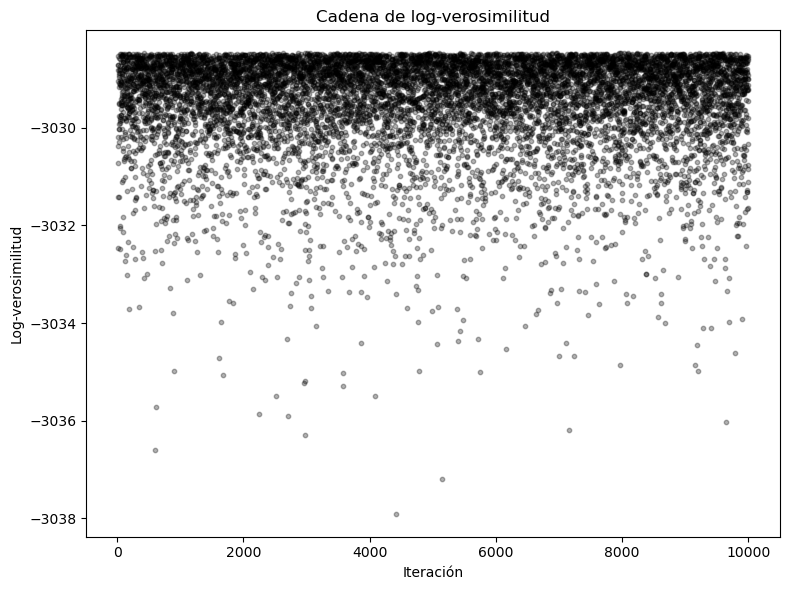

In [26]:
# Calcular la log-verosimilitud para cada iteración
ll = np.array([
    np.sum(norm.logpdf(y, loc=THETA["theta"][i], scale=np.sqrt(THETA["sigma2"][i])))
    for i in range(B)
])

# Visualización de la cadena de log-verosimilitud (sin burn-in)
plt.figure(figsize=(8, 6))
plt.scatter(
    np.arange(11, B+1), ll[10:], 
    color=(0, 0, 0, 0.3), s=10  # color negro con alpha
)

plt.xlabel("Iteración")
plt.ylabel("Log-verosimilitud")
plt.title("Cadena de log-verosimilitud")
plt.tight_layout()
plt.show()

## Autocorrelación

La función de autocorrelación se define como  
$$
\operatorname{acf}_{t}(\theta)=\frac{\frac{1}{B-t} \sum_{b=1}^{B-t}\left(\theta^{(b)}-\bar{\theta}\right)\left(\theta^{(b+t)}-\bar{\theta}\right)}{\frac{1}{B-1} \sum_{b=1}^{B}\left(\theta^{(b)}-\bar{\theta}\right)^{2}},
\qquad\text{donde}
\qquad\bar{\theta} = \frac{1}{B}\sum_{b=1}^B \theta^{(b)}.
$$  

Una **mayor autocorrelación** implica la necesidad de **más muestras** para alcanzar la precisión deseada.  

Para reducir la autocorrelación en la cadena, se recomienda:  

- **Adelgazar la cadena** mediante muestreo sistemático.  
- **Reparametrizar el modelo** para mejorar la eficiencia de la exploración del espacio de parámetros.

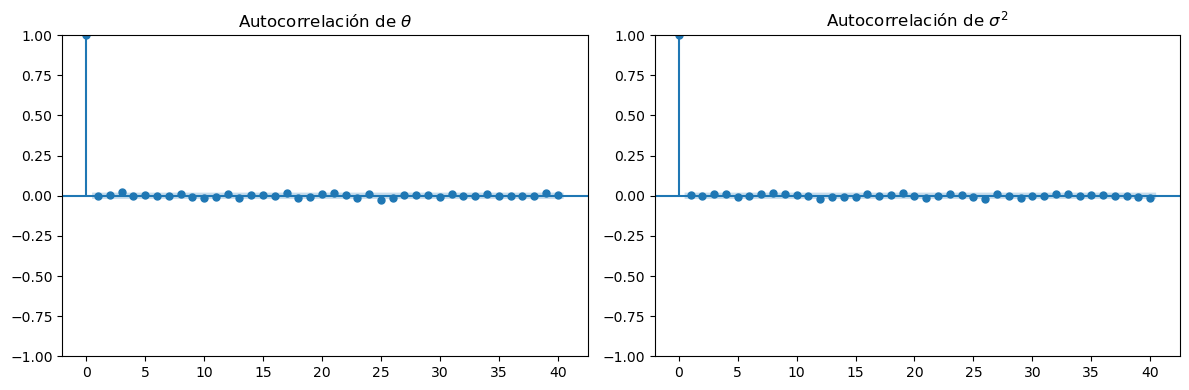

In [28]:
# Crear figura con dos paneles
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace=0.3)

# ACF para theta
plot_acf(THETA["theta"], ax=axes[0], lags=40, alpha=0.05)
axes[0].set_title(r"Autocorrelación de $\theta$")

# ACF para sigma^2
plot_acf(THETA["sigma2"], ax=axes[1], lags=40, alpha=0.05)
axes[1].set_title(r"Autocorrelación de $\sigma^2$")

plt.tight_layout()
plt.show()

## Tamaño efectivo de muestra

Las cadenas generadas suelen presentar **autocorrelación**, lo que implica que **aportan menos información** en comparación con una secuencia de muestras **independientes e idénticamente distribuidas** (IID) de la distribución posterior.  

El **tamaño efectivo de la muestra** representa la cantidad de muestras IID que contendrían la misma información que la cadena, y se define como:
$$
n_{\text{eff}}(\theta) = \frac{B}{1+2\sum_{t=1}^\infty \text{acf}_t(\theta)}\,,
$$  
donde $\text{acf}_t(\theta)$ es la autocorrelación en el rezago $t$. En la práctica, la suma se trunca cuando **dos términos consecutivos se vuelven negativos**, es decir, cuando se cumple que  
$$
\text{acf}_{t-1} + \text{acf}_t < 0.
$$  
Este criterio evita la inclusión de contribuciones espurias en la estimación del tamaño efectivo de la muestra. 

In [30]:
def effective_size(x, max_lag=1000):
    """
    Calcula el tamaño efectivo de muestra (ESS) siguiendo el criterio de Geyer,
    equivalente a coda::effectiveSize en R.

    Parámetros:
    - x: array unidimensional con la cadena MCMC.
    - max_lag: número máximo de retardos (por defecto 1000).

    Retorna:
    - ESS: tamaño efectivo de muestra.
    """
    x = np.asarray(x)
    n = len(x)
    x_centered = x - np.mean(x)
    var = np.var(x_centered, ddof=0)

    # Autocorrelaciones (biased estimator)
    acf = np.correlate(x_centered, x_centered, mode='full')[n-1:] / (var * n)
    acf = acf[:max_lag]

    # Geyer truncation: usar pares de autocorrelaciones mientras su suma sea positiva
    t = 1
    while t + 1 < len(acf) and (acf[t] + acf[t + 1]) > 0:
        t += 2

    # Suma truncada
    tau = 1 + 2 * np.sum(acf[1:t])
    ess = n / tau
    return ess

In [31]:
# Calcular tamaños efectivos de muestra
ess_theta = round(effective_size(THETA["theta"]))
ess_sigma2 = round(effective_size(THETA["sigma2"]))

# Mostrar resultados
print("Tamaños efectivos de muestra:")
print(f"theta:   {ess_theta}")
print(f"sigma²:  {ess_sigma2}")

Tamaños efectivos de muestra:
theta:   9294
sigma²:  9471


## Error estándar de Monte Carlo
  
El **error estándar de Monte Carlo** (EMC) mide la desviación estándar del promedio muestral ajustado por el **tamaño efectivo de la muestra**:  
$$
\textsf{EMC}(\hat\theta) = \frac{\textsf{DE}(\hat\theta)}{\sqrt{n_{\text{eff}}(\theta)}}\,,
$$  
donde $\hat\theta = \frac{1}{B} \sum_{b=1}^B \theta^{(b)}$ es la media posterior, $\textsf{DE}(\hat\theta) = \sqrt{\frac{1}{B-1} \sum_{b=1}^B (\theta^{(b)} - \hat\theta)^2}$ es la desviación estándar posterior, y $n_{\text{eff}}$ es el tamaño efectivo de la muestra.  

El EMC cuantifica la **precisión de la estimación** de $\hat\theta$, disminuyendo conforme aumenta $n_{\text{eff}$, lo que implica una mayor eficiencia en la simulación.

In [33]:
# Vector de tamaños efectivos
neff_vec = np.array([ess_theta, ess_sigma2])

# Calcular el error estándar de Monte Carlo para cada parámetro
emc = THETA.std(ddof=1) / np.sqrt(neff_vec)

# Redondear a 4 cifras decimales
emc = emc.round(4)

# Mostrar resultado
print("Error estándar de Monte Carlo (EMC):")
print(emc)

Error estándar de Monte Carlo (EMC):
theta     0.0045
sigma2    0.0743
dtype: float64


In [34]:
# Calcular medias posteriores absolutas
means = THETA.mean().abs()

# Coeficiente de variación de Monte Carlo (%)
cvmc = 100 * emc / means

# Redondear a 4 cifras decimales
cvmc = cvmc.round(4)

# Mostrar resultado
print("Coeficiente de variación de Monte Carlo (CVMC) [%]:")
print(cvmc)

Coeficiente de variación de Monte Carlo (CVMC) [%]:
theta     0.0082
sigma2    0.0516
dtype: float64


## Prueba de Gelman-Rubin

La prueba de Gelman-Rubin evalúa la convergencia en algoritmos MCMC comparando la varianza entre cadenas con la varianza dentro de cada cadena.  

Dado un conjunto de $M$ cadenas de longitud $B$, se define la **varianza dentro de las cadenas** como  
$$
\textsf{W} = \frac{1}{M} \sum_{m=1}^{M} s_m^2, \quad \text{donde} \quad s_m^2 = \frac{1}{B-1} \sum_{b=1}^{B} (\theta_m^{(b)} - \bar{\theta}_m)^2.
$$  
y la **varianza entre las cadenas** como  
$$
\textsf{B} = \frac{B}{M-1} \sum_{m=1}^{M} (\bar{\theta}_m - \bar{\theta})^2, \quad \text{donde} \quad \bar{\theta} = \frac{1}{M} \sum_{m=1}^{M} \bar{\theta}_m.
$$  

A partir de esto, el **estimador de la varianza total** es  
$$
\hat{\sigma}^2 = \frac{B - 1}{B} \, \textsf{W} + \frac{1}{B} \, \textsf{B},
$$  
y el **estadístico de Gelman-Rubin** se define como  
$$
\hat{R} = \sqrt{\frac{\hat{\sigma}^2}{\textsf{W}}}.
$$  
Si $\hat{R} \approx 1$, las cadenas han convergido; si $\hat{R} > 1.1$, se recomienda continuar la simulación. Valores grandes indican que la exploración del espacio de parámetros es insuficiente.

In [36]:
def gibbs_sampler(y, B, mu0, t20, nu0, s20, verbose=True):
    """
    Implementa un muestreador de Gibbs para un modelo normal jerárquico con sigma^2 desconocida.
    
    Parámetros:
    - y: datos observados (array-like)
    - B: número de iteraciones
    - mu0, t20: hiperparámetros para theta
    - nu0, s20: hiperparámetros para sigma^2
    - verbose: si True, muestra el progreso cada 10%
    
    Retorna:
    - DataFrame con columnas 'theta' y 'sigma2'
    """
    y = np.asarray(y)
    n = len(y)
    yb = np.mean(y)

    # Inicialización
    sig2 = 1 / gamma.rvs(a=nu0 / 2, scale=2 / (nu0 * s20))
    THETA = np.empty((B, 2))

    for b in range(B):
        # Actualización de theta
        t2n = 1 / (1 / t20 + n / sig2)
        mun = t2n * (mu0 / t20 + n * yb / sig2)
        theta = norm.rvs(loc=mun, scale=np.sqrt(t2n))

        # Actualización de sigma^2
        nun = nu0 + n
        s2n = (nu0 * s20 + np.sum((y - theta) ** 2)) / nun
        sig2 = 1 / gamma.rvs(a=nun / 2, scale=2 / (nun * s2n))

        # Almacenar muestras
        THETA[b, :] = [theta, sig2]

        # Progreso
        if verbose and b % (B // 10) == 0:
            print(f"{int(100 * b / B)}% completado...")

    # Convertir a DataFrame
    return pd.DataFrame(THETA, columns=["theta", "sigma2"])


In [37]:
# Semilla para reproducibilidad
np.random.seed(123)

# Ejecutar 3 cadenas independientes
cadena_1 = gibbs_sampler(y, B, mu0, t20, nu0, s20, verbose=False)
cadena_2 = gibbs_sampler(y, B, mu0, t20, nu0, s20, verbose=False)
cadena_3 = gibbs_sampler(y, B, mu0, t20, nu0, s20, verbose=False)

In [38]:
# Convertir a InferenceData (shape: [chains, draws])
idata = az.from_dict(posterior={
    "theta": np.stack([cadena_1["theta"], cadena_2["theta"], cadena_3["theta"]]),
    "sigma2": np.stack([cadena_1["sigma2"], cadena_2["sigma2"], cadena_3["sigma2"]])
})

# Calcular R-hat (Gelman-Rubin)
rhat = az.rhat(idata)

# Mostrar resultados
print("Diagnóstico de Gelman-Rubin (R-hat):")
print(rhat)

Diagnóstico de Gelman-Rubin (R-hat):
<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    theta    float64 8B 1.0
    sigma2   float64 8B 1.0


## Más diagnósticos

- `heidel` : Prueba estacionariedad y recomienda descartar un número óptimo de iteraciones iniciales para asegurar convergencia.  
- `geweke` : Compara medias al inicio y al final de la cadena para detectar diferencias significativas que indiquen falta de convergencia.
- `raftery`: Estima el número mínimo de iteraciones necesarias para garantizar intervalos de credibilidad con una precisión y cobertura deseada.

# Ejercicios

- Demuestre que la distribución t se puede expresar como una mezcla de distribuciones Normales ponderadas por una distribución Gamma-Inversa. Es decir, demostrar que la distribución muestral $y_{i}\mid\theta,\sigma^2 \stackrel{\text {iid}}{\sim} \textsf{t}_\kappa(\theta,\sigma^2)$, para $i=1,\ldots,n$, es equivalente a la distribución jerárquica dada por
$$
y_{i}\mid\theta,V_i \stackrel{\text {ind}}{\sim} \textsf{N}(\theta,V_i)\,,\qquad
V_{i}\mid\sigma^2\stackrel{\text {iid}}{\sim}  \textsf{GI}\left( \frac{\kappa}{2}, \frac{\kappa\,\sigma^2}{2}\right)\,.
$$

- Considere los datos sobre el número de hijos de hombres en sus 30s, con y sin título universitario, reportados en `menchild30bach.dat` y `menchild30nobach.dat`. Asuma modelos Poisson para ambos grupos, pero ahora parametrizamos $\theta_A$ y $\theta_B$ como $\theta_A = \theta$ y $\theta_B = \theta \times \phi$, donde $\phi$ representa la razón relativa $\theta_B / \theta_A$. Suponemos distribuciones previas $\theta \sim \textsf{Gamma}(a_\theta, b_\theta)$ y $\phi \sim \textsf{Gamma}(a_\phi, b_\phi)$.

     a. ¿Son $\theta_A$ y $\theta_B$ independientes o dependientes bajo esta distribución previa? ¿En qué situaciones se justifica el uso de una distribución previa de este tipo?  
     b. Obtenga la distribución condicional completa de $\theta$.  
     c. Obtenga la distribución condicional completa de $\phi$.  
     d. Fije $a_\theta = 2$ y $b_\theta = 1$. Considere $a_\phi = b_\phi \in \{8, 16, 32, 64, 128\}$. Para cada uno de estos cinco valores, implemente un muestreador de Gibbs con al menos 10,000 iteraciones. Realice un análisis exhaustivo de convergencia.
     e. Estime $\textsf{E}(\theta_B - \theta_A \mid \boldsymbol{y}_A, \boldsymbol{y}_B)$ en cada caso. Describa los efectos de la distribución previa de $\phi$ sobre los resultados

- El archivo `glucose.dat` contiene las concentraciones de glucosa en plasma de 532 mujeres en un estudio sobre diabetes.

     a. Realice un histograma de los datos. Describa cómo la distribución empírica difiere de una distribución Normal en términos de asimetría, curtosis u otras características relevantes.
     
     b. Considere el siguiente modelo de mezcla para estos datos. Cada participante del estudio tiene asociada una variable latente (no observada) de pertenencia a un grupo $\xi_i$, que sigue una distribución Bernoulli con probabilidad $\omega$, de forma que $\xi_i = 1$ con probabilidad $\omega$ y $\xi_i = 2$ con probabilidad $1 - \omega$. Si $\xi_i = 1$, entonces $y_i \mid \theta_1, \sigma_1^2 \sim \textsf{N}(\theta_1, \sigma_1^2)$, y si $\xi_i = 2$, entonces $y_i \mid \theta_2, \sigma_2^2 \sim \textsf{N}(\theta_2, \sigma_2^2)$. Las distribuciones previas están dadas por $\omega    \sim \textsf{Beta}(\alpha_0, \beta_0)$, $\theta_j  \sim \textsf{N}(\mu_0, \tau_0^2)$, $\sigma_j^2 \sim \textsf{GI}(\nu_0/2, \nu_0\,\sigma_0^2/2)$, para $j = 1,2$. Obtenga las distribuciones condicionales completas de $\xi_1, \dots, \xi_n$, $\omega$, $\theta_1$, $\theta_2$, $\sigma_1^2$ y $\sigma_2^2$.
     
     c. Fijando $\alpha_0 = \beta_0 = 1$, $\mu_0 = 120$, $\tau_0^2 = 200$, $\sigma_0^2 = 1000$ y $\nu_0 = 10$, implemente un muestreador de Gibbs con al menos 10,000 iteraciones. Realice un análisis exhaustivo de convergencia.
     
     d. Para cada iteración $b$ del muestreador de Gibbs, denere un valor $\xi \sim \textsf{Ber}(\omega^{(b)})$ y luego muestree $y^{*\,(b)} \sim \textsf{N}(\theta_{\xi}^{(b)}, \sigma_{\xi}^{2\,(b)})$, para $b = 1,\ldots,B$. Por medio de un histograma, represente la distribución de $y^{*\,(1)}, \dots, y^{*\,(B)}$ y compárela con la distribución obtenida en la parte a. Discuta la adecuación de este modelo de mezcla de dos componentes para los datos de glucosa.

- Un estudio de panel siguió a 25 parejas casadas durante cinco años para analizar la relación entre las tasas de divorcio y diversas características de las parejas. Los investigadores buscan modelar la probabilidad de divorcio en función de estas características. Los datos están disponibles en el archivo `divorce.dat`. Se utilizará regresión probit, donde una variable binaria $y_i$ se modela mediante la siguiente formulación usando variables latentes:  
$$
z_i = \beta x_i + \epsilon_i, \quad 
y_i = I(z_i > \delta), \quad \text{para } i = 1,\ldots,n,
$$
donde $\beta$ y $\delta$ son parámetros desconocidos, $\epsilon_i \overset{\text{iid}}{\sim} \textsf{N}(0,1)$ para $i=1,\ldots,n$, y $I(z_i > \delta)$ es una función indicadora que toma el valor 1 si $z_i > \delta$ y 0 en caso contrario.

     a. Determine la distribución condicional completa de $\beta$, asumiendo que $\beta \sim \textsf{N}(0, \tau^2_0)$.
     b. Determine que la distribución condicional completa de $\delta$, asumiendo que $\delta \sim \textsf{N}(0, \kappa^2_0)$.
     c. Determine la distribución condicional completa de $z_i$.
     d. Fijando $\tau^2_0 = \kappa^2_0 = 16$, implemente un muestreador de Gibbs para aproximar la distribución posterior conjunta de $z_1,\ldots z_n$, $\beta$ y $\delta$. Ejecute el muestreador de Gibbs el tiempo suficiente para que los tamaños efectivos de muestra de todos los parámetros desconocidos, incluidos los $z_i$, sean mayores a 1,000. Realice un análisis exhaustivo de convergencia.
     e. Obtenga un intervalo de credibilidad posterior del 95% para $\beta$, así como $\textsf{Pr}(\beta > 0 \mid \boldsymbol{x}, \boldsymbol{y})$. Discuta los resultados obtenidos.

- Sea $y_t = \rho y_{t-1} + \epsilon_t$, donde $\epsilon_t$ es un proceso i.i.d. con $\epsilon_t \sim \textsf{N}(0, \sigma^2)$. Este es un modelo ampliamente utilizado en el análisis de series temporales conocido como el modelo autorregresivo de orden uno (AR(1)).  

    a. Escriba la verosimilitud condicional dada $y_1$, es decir, $p(y_2, \dots, y_n \mid y_1, \rho, \sigma^2)$.  
    b. Suponga una distribución a priori de la forma $p(\rho, \sigma^2) \propto 1/\sigma^2$:  
          
    - Determine la distribución posterior conjunta $p(\rho, \sigma^2 \mid y_1, \dots, y_n)$ basada en la verosimilitud condicional.  
    - Obtenga $p(\rho \mid \sigma^2, y_1, \dots, y_n)$ y $p(\sigma^2 \mid y_1, \dots, y_n)$ utilizando la verosimilitud condicional.  
    - Simule dos conjuntos de datos con $n = 500$ observaciones cada uno: uno con $\rho = 0.95$, $\sigma^2 = 4$ y otro con $\rho = 0.3$, $\sigma^2 = 4$. Ajuste el modelo a ambos conjuntos de datos y resuma los resultados posteriores en cada caso.

- La base de datos `personas.csv`, disponible en la página web del curso, es una muestra del módulo de Personas de la encuesta Medición de Pobreza Monetaria y Desigualdad 2021, realizada por el DANE en Colombia ([enlace oficial](https://microdatos.dane.gov.co/index.php/catalog/733)). La muestra incluye a la población civil no institucional residente en el país, con datos recolectados mediante informantes directos (mayores de 18 años o menores que trabajen) o informantes idóneos del hogar. Se considera el ingreso total (`ingtot`), que corresponde a la suma de todas las fuentes de ingresos, tanto observadas como imputadas, específicamente para los habitantes de Bogotá. 

     a. Para ajustar el modelo 
     $$
     y_i \mid \theta, \sigma^2 \overset{\text{iid}}{\sim} \textsf{t}_\kappa(\theta, \sigma^2), \quad \text{para } i = 1, \dots, n,
     $$
     se utilizan las distribuciones previas 
     $$
     \theta \sim \textsf{N}(\mu_0, \gamma_0^2), \quad
     \sigma^2 \sim \textsf{Gamma}\left(\frac{\alpha_0}{2}, \frac{\beta_0}{2}\right), \quad
     \kappa \sim \textsf{U}\{1, 2, \dots, \nu_0\},
     $$
     donde $\mu_0$, $\gamma_0^2$, $\alpha_0$, $\beta_0$ y $\nu_0$ son hiperparámetros del modelo. La distribución muestral $y_i \mid \theta, \sigma^2 \overset{\text{iid}}{\sim} \textsf{t}_\kappa(\theta, \sigma^2)$ se puede reformular de manera jerárquica como  
     $$
     y_i \mid \theta, \zeta_i^2 \overset{\text{ind}}{\sim} \textsf{N}(\theta, \zeta_i^2), \quad \zeta_i^2 \mid \sigma^2 \overset{\text{iid}}{\sim} \textsf{GI}\left(\frac{\kappa}{2}, \frac{\kappa \sigma^2}{2} \right),
     $$  
     donde las variables auxiliares $\zeta_i^2$, aunque desconocidas, se introducen para facilitar la implementación del muestreador de Gibbs. Su incorporación permite que las distribuciones condicionales completas de los parámetros desconocidos, incluidas las auxiliares, tengan formas probabilísticas estándar, lo que simplifica significativamente el proceso de muestreo.
     
     b. Realizar inferencia sobre la media, la desviación estándar y el coeficiente de variación de los ingresos en escala logarítmica. Dado que, si $X \mid \kappa, \theta, \sigma^2 \sim \textsf{t}_\kappa(\theta, \sigma^2)$, entonces  
     $$
     \textsf{E}(X) = \theta, \quad \text{para } \kappa > 1, \qquad  
     \textsf{Var}(X) = \frac{\kappa}{\kappa - 2} \sigma^2, \quad \text{para } \kappa > 2,
     $$  
     se puede calcular la desviación estándar como $\textsf{DE}(X) = \sqrt{\textsf{Var}(X)}$ y el coeficiente de variación como $\textsf{CV}(X) = \textsf{DE}(X) / \textsf{E}(X)$.
     
     c. En el modelo jerárquico, las variables auxiliares $\zeta_i^2$ juegan un papel fundamental en la detección de valores atípicos, ya que representan la varianza específica de cada observación $y_i$. Estas variables permiten que el modelo ajuste dinámicamente la dispersión en torno a la media $\theta$, asignando una mayor varianza a las observaciones que se desvían significativamente del patrón general. Este mecanismo mejora la identificación de outliers sin distorsionar las estimaciones globales del modelo. Aplique los siguientes métodos para detectar valores atípicos en los ingresos (en escala logarítmica):
     
     - Criterio basado en \(\zeta_i^2\): Identifique las observaciones asociadas con valores de \(\zeta_i^2\) considerablemente altos en comparación con el resto. Como referencia, se pueden considerar outliers aquellas observaciones cuyo valor medio posterior de \(\zeta_i^2\) supere un umbral, como el percentil 95 de la distribución estimada de \(\zeta_i^2\). Estas observaciones son indicativas de outliers, ya que el modelo les asigna una varianza elevada para reflejar su desviación respecto a la media \(\theta\).
     - Criterio basado en residuos estandarizados: Calcule los residuos estandarizados utilizando la fórmula:
       $$
       r_i = \frac{y_i - \theta}{\sqrt{\zeta_i^2}},
       $$
       donde valores absolutos grandes de \(r_i\), típicamente $|r_i| > 3$, sugieren la presencia de outliers. Este enfoque combina la desviación de $y_i$ respecto a $\theta$ y la varianza específica $\zeta_i^2$, proporcionando una medida confiable para identificar valores extremos.
               
    - Ambos criterios pueden ser complementados mediante visualizaciones, como gráficos de los valores estimados de $\zeta_i^2$ o de los residuos estandarizados $r_i$. Estas herramientas permiten una exploración más intuitiva y detallada de los posibles outliers en el conjunto de datos.

# Referencias

Hoff, P. D. (2009). ***A First Course in Bayesian Statistical Methods***. Springer New York.

Gelman, A., Carlin, J. B., Stern, H. S., Dunson, D. B., Vehtari, A., & Rubin, D. B. (2013). ***Bayesian Data Analysis*** (3rd ed.). Chapman & Hall/CRC.